<div style="font-size: 200%; font-weight: bold; color: maroon;">Machine Learning en Python: vuelos a Nueva York durante 2014</div>

# Introducción

A partir de una base de datos de vuelos internos a Nueva York en el año 2014, que cuenta con más de 250.000 registros de vuelos, se analizarán sus retrasos y se mostrarán gráficamente.

Por último, se emplearán técnicas de *Machine Learning*, para construir un clasificador del tipo "Random Forest", que permitirá predecir si un vuelo sufrirá o no un "retraso importante".

# Preparación

En primer lugar, importamos las funciones de Python necesarias para este análisis y cargamos un DataFrame de datos de vuelos a Nueva York durante 2014.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd

In [2]:
flights = pd.read_csv( 'DATOS/flights14.csv.bz2' )

In [3]:
flights.shape

(253316, 17)

La siguiente tabla muestra las columnas que tiene el DataFrame, y qué datos contienen:

|columna|contenido
| :- | :------------- |
|`year`|fecha del vuelo (año)
|`month`|fecha del vuelo (mes)
|`day`|fecha del vuelo (día)
|`dep_time`|hora real de salida
|`dep_delay`|retraso en salida (minutos)
|`arr_time`|hora de llegada
|`arr_delay`|retraso en llegada (minutos)
|`cancelled`|vuelo cancelado
|`carrier`|compañía
|`tailnum`|número de avión
|`flight`|número de vuelo
|`origin`|aeropuerto de origen
|`dest`|aeropuerto de destino
|`air_time`|tiempo de vuelo (minutos)
|`distance`|distancia recorrida (millas)
|`hour`|hora prevista de salida
|`min`|minuto previsto de salida


# 1. Análisis de retrasos

## 1.1 Retraso importante

Vamos a definir "_retraso importante_" como un retraso en la llegada del vuelo de más de una hora.

Añadimos una columna con el nombre "`retraso_importante`" al DataFrame. La columna tendrá un valor booleano: `True` si el vuelo ha tenido más de una hora de retraso _en la llegada_ y `False` en caso contrario.

In [4]:
# Definición de retraso_importante en el dataframe
flights.loc[:,'retraso_importante'] = flights.loc[:,'arr_delay']>60

In [5]:
# Verficación que la nueva columna está incluida
flights.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,cancelled,carrier,tailnum,flight,origin,dest,air_time,distance,hour,min,retraso_importante
0,2014,1,1,914,14,1238,13,0,AA,N338AA,1,JFK,LAX,359,2475,9,14,False
1,2014,1,1,1157,-3,1523,13,0,AA,N335AA,3,JFK,LAX,363,2475,11,57,False
2,2014,1,1,1902,2,2224,9,0,AA,N327AA,21,JFK,LAX,351,2475,19,2,False
3,2014,1,1,722,-8,1014,-26,0,AA,N3EHAA,29,LGA,PBI,157,1035,7,22,False
4,2014,1,1,1347,2,1706,1,0,AA,N319AA,117,JFK,LAX,350,2475,13,47,False


## 1.2 Retrasos por compañía

Contamos cuántos vuelos con "retraso importante" ha tenido cada compañía y ordenenamos el resultado, obteniendo la lista de compañías ordenadas por su número de retrasos importantes de mayor a menor.

In [6]:
# Agrupación y cálculo de retrasos por compañia
groups = flights.groupby('carrier')

retraso_aerolineas=groups['retraso_importante'].sum().sort_values(ascending=False)
retraso_aerolineas

carrier
EV    4595.0
B6    3767.0
UA    3642.0
DL    2829.0
AA    1852.0
MQ    1446.0
WN    1163.0
US     718.0
VX     325.0
FL     133.0
F9      76.0
AS      39.0
OO      19.0
HA      19.0
Name: retraso_importante, dtype: float64

Las tres compañias con más "retrasos importantes" en vuelos a Nueva York en 2014 fueron: EV (ExpressJet Airlines), B6 (Jetblue) y UA (United Airlines).

# 2. Representación gráfica

Representamos los resultados en dos gráficas, cada una con una nube de puntos tipo (_scatter_):
* El retraso en la llegada (minutos) como función de la distancia recorrida (millas)
* El retraso en la llegada (minutos) como función de la hora de salida (hhmm)

In [10]:
# Importación de paquetes y preparación de los gráficos
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (15, 6)

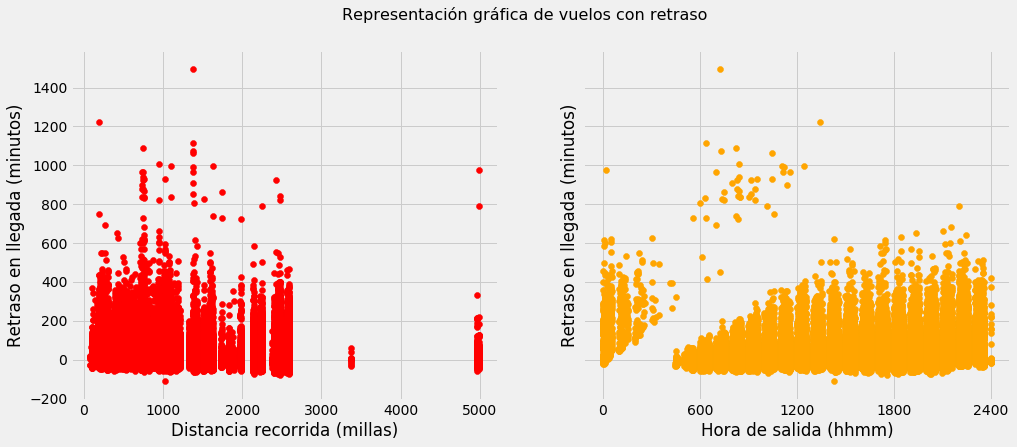

In [11]:
# Creación de los gráficos
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)

x1 = flights.distance
x2 = flights.dep_time
y = flights.arr_delay

ax1.scatter(x1,y, c='r')
ax2.scatter(x2,y, c='orange')

fig.suptitle("Representación gráfica de vuelos con retraso", fontsize=16)
ax1.set_xlabel("Distancia recorrida (millas)")
ax2.set_xlabel("Hora de salida (hhmm)")
ax1.set_ylabel("Retraso en llegada (minutos)")
ax2.set_ylabel("Retraso en llegada (minutos)")
ax2.set_xticks([0, 600, 1200, 1800, 2400]);

# 3. Machine Learning - Clasificación

Vamos a entrenar un clasificador tipo "Random Forest" para que prediga si el vuelo tiene o no "retraso importante" en función de la distancia recorrida y la hora real de salida. La hora real de salida se calcula a partir de la hora prevista de salida más el retraso correspondiente.

Para ello seleccionamos las columnas de _distancia recorrida_ y _hora real de salida_ como datos de entrada  y la columna creada de _retraso importante_ como dato de salida. A continuación, separamos los datos en conjunto de entrenamiento (75%) y conjunto de test (25%).

In [12]:
# Carga de los paquetes 
from sklearn.model_selection import train_test_split

# Cálculo hora real de salida (hora prevista + retraso)
flights.loc[:,'hora_r_salida'] = flights.loc[:,'dep_time']+flights.loc[:,'dep_delay']

# Selección de datos
X=flights[['distance','hora_r_salida']]
Y=flights['retraso_importante']

# Separación de datos entrenamiento y test
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size=0.25)

Seguidamente entrenenamos un clasificador `RandomForest` con 100 árboles, usando el conjunto de entrenamiento.

In [13]:
# Carga y entrenamiento del Random Forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100).fit( Xtrain, Ytrain )
Ypred = RF.predict( Xtest )

Por último calculamos sobre el conjunto de test: la exactitud (`accuracy`) y la matriz de confusión (`confusion matrix`).

In [14]:
# Cálculo de exactitud
from sklearn.metrics import accuracy_score, confusion_matrix

print( "Accuracy =", accuracy_score( Ytest, Ypred ) )

Accuracy = 0.9261633690726208


In [15]:
# Cálculo matriz de confusión
c=confusion_matrix( Ytest, Ypred )
print(c)

[[56654  1547]
 [ 3129  1999]]


In [16]:
Aciertos=c[0,0]+c[1,1]
Aciertos

58653

In [17]:
Fallos=c[0,1]+c[1,0]
Fallos

4676

Se puede concluir que los resultados obtenidos con el clasificador `RandomForest` entrenado son bastante precisos. 

Del conjunto de datos de test se han obtenido un total de 58.653 aciertos y tan sólo 4.676 fallos, lo que supone más de un 92,6% de exactitud con los datos de los vuelos internos a Nueva York en el año 2014.

Gracias a este modelo de Machine Learning podriamos predecir si nuestro vuelo a Nueva York puede sufrir un retraso importante.

## 4. Ejemplo de aplicación

Supongamos que queremos predecir si nuestro próximo vuelo a Nueva York sufrirá o no un retraso importante.

En este caso necesitaremos los datos de distancia y hora real de salida (en este caso usaríamos la hora prevista en el billete) y los introduciríamos en el modelo.

Para ello vamos a usar de ejemplo un vuelo V1 con una distancia de 2500 millas que sale a las 9:30 y un vuelo V2 de 200 millas que despega a la 23:45.

In [18]:
V1 = [{'distance': 2500, 'hora_r_salida': 930}]

In [19]:
V2 = [{'distance': 200, 'hora_r_salida': 2345}]

In [20]:
dfV1 = pd.DataFrame(V1)

In [21]:
dfV2 = pd.DataFrame(V2)

In [22]:
YpredV1 = RF.predict( dfV1 )

In [23]:
YpredV1

array([False])

In [24]:
YpredV2 = RF.predict( dfV2 )

In [25]:
YpredV2

array([ True])

Si observamos los resultados finales, el modelo de Machine Learning ha sido capaz de predecir que el vuelo V2 sufrirá un retraso importante mientras que el vuelo V1 llegará en hora o con poco retraso.